# ΓΙΑΝΝΗΣ ΚΑΡΑΒΕΛΛΑΣ
# 4228

In [1]:
import numpy as np
import cupy as cp
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import random
import pandas as pd

Loading the data

In [2]:
cp.random.seed(42)  
np.random.seed(42)
random.seed(42)
# Load the dataset
(x_train_full, y_train_full), (x_test_full, y_test_full) = cifar10.load_data()

# Flatten label arrays
y_train_full = y_train_full.flatten()
y_test_full = y_test_full.flatten()


Extracting only 'cat' and 'dog' lables

In [3]:
# Define the classes
class_map = {5: 'dog', 3: 'cat'}

# Filter training data
train_filter = np.isin(y_train_full, list(class_map.keys()))
x_train = x_train_full[train_filter]
y_train = y_train_full[train_filter]

# Filter test data
test_filter = np.isin(y_test_full, list(class_map.keys()))
x_test = x_test_full[test_filter]
y_test = y_test_full[test_filter]

# Map labels to +1 and -1
label_map = {5: 1, 3: -1}
y_train = np.vectorize(label_map.get)(y_train)
y_test = np.vectorize(label_map.get)(y_test)

# Flatten the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

# Normalize pixel values to [0, 1]
x_train = x_train.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255

x_train_mean = cp.mean(x_train, axis=0)
x_train_std = cp.std(x_train, axis=0)
x_train = (x_train - x_train_mean) / x_train_std
x_test = (x_test - x_train_mean) / x_train_std




converting to CuPy arrays

In [4]:

x_train = cp.array(x_train)
y_train = cp.array(y_train)
x_test = cp.array(x_test)
y_test = cp.array(y_test)

# Shuffle the data randomly
indices = cp.arange(x_train.shape[0])
cp.random.shuffle(indices)

# Apply shuffled indices to x_train and y_train
x_train = x_train[indices]
y_train = y_train[indices]




# SVM functions

In [5]:
def up_then_down_scheduler(epoch, total_epochs, ramp_up_epochs, min_lr, max_lr):
    if epoch <= ramp_up_epochs:
        # Linear ramp-up
        lr = min_lr + (max_lr - min_lr) * (epoch / ramp_up_epochs)
    else:
        # Linear ramp-down
        lr = max_lr - (max_lr - min_lr) * ((epoch - ramp_up_epochs) / (total_epochs - ramp_up_epochs))
    return lr


In [ ]:

# Polynomial Kernel Function
def polynomial_kernel(X, Y, degree=3, coef0=1):
    return (cp.dot(X, Y.T) + coef0) ** degree

# Dual SVM Class with Gradient Descent
class GradientSVM:
    def __init__(self, C=1.0, epochs=100, degree=3, coef0=1):
        self.kernel = polynomial_kernel
        self.C = C
        self.epochs = epochs
        self.degree = degree
        self.coef0 = coef0
        self.alphas = None
        self.b = 0
        self.K = None
        self.X = None
        self.y = None
        self.support_vectors = None
        self.support_alphas = None
        self.support_y = None

    def fit(self, X, y, x_test, y_test, min_lr, max_lr, ramp_up_epochs):
        train_accuracies = []
        test_accuracies = []
        lr_history = []
        self.X = X
        self.y = y
        m, n = X.shape
        self.alphas = cp.zeros(m)
        self.b = 0
        self.K = self.kernel(X, X, degree=self.degree, coef0=self.coef0)

        for epoch in tqdm(range(self.epochs), desc='Training Epochs'):
            lr = up_then_down_scheduler(epoch, self.epochs, ramp_up_epochs, min_lr, max_lr)
            for i in range(m):
                # Compute the decision function for xi
                f_i = cp.sum(self.alphas * self.y * self.K[:, i]) + self.b
                

                # Compute gradient for alpha_i
                gradient = 1 - self.y[i] * f_i

                # Update rule
                if (self.y[i] * f_i < 1):
                    # Gradient for alpha_i
                    grad_alpha_i = gradient  
                    # Update alpha_i
                    self.alphas[i] += lr * grad_alpha_i
                    # Clip alpha_i to [0, C]
                    self.alphas[i] = cp.clip(self.alphas[i], 0, self.C)
                else:

                    continue

            # Update bias term b
            # Identify support vectors (0 < alpha_i < C)
            support_vector_indices = cp.where((self.alphas > 1e-5) & (self.alphas < self.C))[0]
            if len(support_vector_indices) > 0:
                # Compute the sum over all alpha_j * y_j * K(x_j, x_i) for each support vector i
                # Reshape alphas * y for broadcasting
                sum_alpha_y_K = cp.sum((self.alphas * self.y)[:, cp.newaxis] * self.K[:, support_vector_indices], axis=0)
                
                # Compute b as the mean of (y_i - sum_alpha_y_K) over support vectors
                self.b = cp.mean(y[support_vector_indices] - sum_alpha_y_K)
            else:
                self.b = 0
            y_pred_train = cp.sign(self.decision_function(X, use_support_vectors=False))
            y_pred_test = cp.sign(self.decision_function(x_test, use_support_vectors=False))
            # Convert predictions and labels to CPU (NumPy) arrays for evaluation
            y_pred_train_cpu = cp.asnumpy(y_pred_train)
            y_pred_test_cpu = cp.asnumpy(y_pred_test)
            y_train_cpu = cp.asnumpy(y_train)
            y_test_cpu = cp.asnumpy(y_test)
            # Calculate accuracy
            train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
            test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)
            train_accuracies.append(train_accuracy)
            test_accuracies.append(test_accuracy)
            lr_history.append(lr)


       

        # Extract support vectors after training
        self.support_vector_indices = cp.where(self.alphas > 1e-5)[0]
        self.support_vectors = self.X[self.support_vector_indices]
        self.support_alphas = self.alphas[self.support_vector_indices]
        self.support_y = self.y[self.support_vector_indices]

        return train_accuracies, test_accuracies, lr_history


    def decision_function(self, X, use_support_vectors=False):
        if use_support_vectors and self.support_vectors is not None:
            # Compute the kernel between X and support vectors
            K = self.kernel(X, self.support_vectors, degree=self.degree, coef0=self.coef0) 
            # Compute the decision function
            return cp.dot(K, self.support_alphas * self.support_y) + self.b 
        else:
            # Use all data (during training)
            K = self.kernel(X, self.X, degree=self.degree, coef0=self.coef0)
            return cp.dot(K, self.alphas * self.y) + self.b
        

    def predict(self, X):
        decision_values = self.decision_function(X, use_support_vectors=True)
        return cp.sign(decision_values)



# Training section

In [7]:
from itertools import product

# Define the hyperparameter grid
C_values = [1e-3, 1e-2, 1e-1, 1, 10, 100]
degree_values = [2, 3, 4, 5]
coef0_values = [0, 2.5, 5, 7.5, 10]

# Create a list of all possible hyperparameter combinations
hyperparameter_grid = list(product(C_values, degree_values, coef0_values))

print(f"Total hyperparameter combinations: {len(hyperparameter_grid)}")

Total hyperparameter combinations: 120


In [8]:
# Initialize a list to store the results
results = []

# Total number of combinations
total_combinations = len(hyperparameter_grid)

# Iterate over each hyperparameter combination
for idx, (C, degree, coef0) in enumerate(tqdm(hyperparameter_grid, desc="Grid Search")):
    print(f"\nEvaluating combination {idx+1}/{total_combinations}: C={C}, Degree={degree}, coef0={coef0}")
    
    # Initialize the DualSVMGradientDescent model with current hyperparameters
    svm = GradientSVM(
        C=C,
        epochs=30,
        degree=degree,
        coef0=coef0
    )
    
    # Train the model on the training subset
    train_accuracies, _, _ = svm.fit(
        X=x_train,
        y=y_train,
        x_test=x_test,
        y_test=y_test,
        min_lr=0.0005,  
        max_lr=0.001,
        ramp_up_epochs=15
    )
    
    # Make predictions on the validation set
    y_pred_test = svm.predict(x_test)
    y_pred_train = svm.predict(x_train)

    # Convert predictions and labels to CPU (NumPy) arrays for evaluation
    y_pred_val_cpu = cp.asnumpy(y_pred_test)
    y_val_cpu = cp.asnumpy(y_test)

    y_pred_train_cpu = cp.asnumpy(y_pred_train)
    y_train_cpu = cp.asnumpy(y_train)
    
    # Calculate validation accuracy
    val_accuracy_test = np.mean(y_pred_val_cpu == y_val_cpu)
    val_accuracy_train = np.mean(y_pred_train_cpu == y_train_cpu )

    
    print(f"test Accuracy: {val_accuracy_test * 100:.2f}%")
    print(f"train Accuracy: {val_accuracy_train * 100:.2f}%")
    
    # Append the results
    results.append({
        'C': C,
        'Degree': degree,
        'coef0': coef0,
        'Test Accuracy': val_accuracy_test,
        'Train Accuracy': val_accuracy_train
    })


Grid Search:   0%|          | 0/120 [00:00<?, ?it/s]


Evaluating combination 1/120: C=0.001, Degree=2, coef0=0


Grid Search:   1%|          | 1/120 [02:08<4:14:20, 128.24s/it]

test Accuracy: 51.40%
train Accuracy: 52.21%

Evaluating combination 2/120: C=0.001, Degree=2, coef0=2.5


Grid Search:   2%|▏         | 2/120 [04:10<4:05:08, 124.64s/it]

test Accuracy: 62.80%
train Accuracy: 73.25%

Evaluating combination 3/120: C=0.001, Degree=2, coef0=5


Grid Search:   2%|▎         | 3/120 [06:09<3:58:32, 122.33s/it]

test Accuracy: 63.70%
train Accuracy: 73.80%

Evaluating combination 4/120: C=0.001, Degree=2, coef0=7.5


Grid Search:   3%|▎         | 4/120 [08:11<3:56:16, 122.21s/it]

test Accuracy: 59.65%
train Accuracy: 68.29%

Evaluating combination 5/120: C=0.001, Degree=2, coef0=10


Grid Search:   4%|▍         | 5/120 [10:13<3:53:55, 122.04s/it]

test Accuracy: 61.85%
train Accuracy: 69.78%

Evaluating combination 6/120: C=0.001, Degree=3, coef0=0


Grid Search:   5%|▌         | 6/120 [12:11<3:48:54, 120.48s/it]

test Accuracy: 60.50%
train Accuracy: 78.65%

Evaluating combination 7/120: C=0.001, Degree=3, coef0=2.5


Grid Search:   6%|▌         | 7/120 [14:09<3:45:32, 119.75s/it]

test Accuracy: 61.10%
train Accuracy: 78.16%

Evaluating combination 8/120: C=0.001, Degree=3, coef0=5


Grid Search:   7%|▋         | 8/120 [16:06<3:41:51, 118.85s/it]

test Accuracy: 61.10%
train Accuracy: 78.95%

Evaluating combination 9/120: C=0.001, Degree=3, coef0=7.5


Grid Search:   8%|▊         | 9/120 [18:04<3:39:18, 118.55s/it]

test Accuracy: 61.95%
train Accuracy: 79.39%

Evaluating combination 10/120: C=0.001, Degree=3, coef0=10


Grid Search:   8%|▊         | 10/120 [20:01<3:36:25, 118.05s/it]

test Accuracy: 62.10%
train Accuracy: 80.80%

Evaluating combination 11/120: C=0.001, Degree=4, coef0=0


Grid Search:   9%|▉         | 11/120 [21:58<3:33:54, 117.75s/it]

test Accuracy: 61.15%
train Accuracy: 81.55%

Evaluating combination 12/120: C=0.001, Degree=4, coef0=2.5


Grid Search:  10%|█         | 12/120 [23:54<3:31:02, 117.25s/it]

test Accuracy: 61.50%
train Accuracy: 81.85%

Evaluating combination 13/120: C=0.001, Degree=4, coef0=5


Grid Search:  11%|█         | 13/120 [25:51<3:28:55, 117.16s/it]

test Accuracy: 61.20%
train Accuracy: 81.45%

Evaluating combination 14/120: C=0.001, Degree=4, coef0=7.5


Grid Search:  12%|█▏        | 14/120 [27:47<3:26:31, 116.90s/it]

test Accuracy: 62.55%
train Accuracy: 81.27%

Evaluating combination 15/120: C=0.001, Degree=4, coef0=10


Grid Search:  12%|█▎        | 15/120 [29:44<3:24:31, 116.88s/it]

test Accuracy: 62.00%
train Accuracy: 82.28%

Evaluating combination 16/120: C=0.001, Degree=5, coef0=0


Grid Search:  13%|█▎        | 16/120 [31:40<3:22:19, 116.72s/it]

test Accuracy: 59.10%
train Accuracy: 80.77%

Evaluating combination 17/120: C=0.001, Degree=5, coef0=2.5


Grid Search:  14%|█▍        | 17/120 [33:37<3:20:21, 116.71s/it]

test Accuracy: 57.65%
train Accuracy: 81.35%

Evaluating combination 18/120: C=0.001, Degree=5, coef0=5


Grid Search:  15%|█▌        | 18/120 [35:33<3:18:08, 116.55s/it]

test Accuracy: 57.70%
train Accuracy: 81.54%

Evaluating combination 19/120: C=0.001, Degree=5, coef0=7.5


Grid Search:  16%|█▌        | 19/120 [37:29<3:16:00, 116.44s/it]

test Accuracy: 58.55%
train Accuracy: 83.02%

Evaluating combination 20/120: C=0.001, Degree=5, coef0=10


Grid Search:  17%|█▋        | 20/120 [39:25<3:13:45, 116.25s/it]

test Accuracy: 58.75%
train Accuracy: 82.05%

Evaluating combination 21/120: C=0.01, Degree=2, coef0=0


Grid Search:  18%|█▊        | 21/120 [41:31<3:16:23, 119.02s/it]

test Accuracy: 61.30%
train Accuracy: 72.47%

Evaluating combination 22/120: C=0.01, Degree=2, coef0=2.5


Grid Search:  18%|█▊        | 22/120 [43:37<3:17:51, 121.14s/it]

test Accuracy: 61.25%
train Accuracy: 64.03%

Evaluating combination 23/120: C=0.01, Degree=2, coef0=5


Grid Search:  19%|█▉        | 23/120 [45:38<3:15:54, 121.18s/it]

test Accuracy: 60.50%
train Accuracy: 68.93%

Evaluating combination 24/120: C=0.01, Degree=2, coef0=7.5


Grid Search:  20%|██        | 24/120 [47:41<3:14:53, 121.81s/it]

test Accuracy: 59.35%
train Accuracy: 65.75%

Evaluating combination 25/120: C=0.01, Degree=2, coef0=10


Grid Search:  21%|██        | 25/120 [49:47<3:14:55, 123.11s/it]

test Accuracy: 63.05%
train Accuracy: 71.99%

Evaluating combination 26/120: C=0.01, Degree=3, coef0=0


Grid Search:  22%|██▏       | 26/120 [51:46<3:10:33, 121.64s/it]

test Accuracy: 61.15%
train Accuracy: 78.10%

Evaluating combination 27/120: C=0.01, Degree=3, coef0=2.5


Grid Search:  22%|██▎       | 27/120 [53:44<3:07:10, 120.76s/it]

test Accuracy: 60.95%
train Accuracy: 78.09%

Evaluating combination 28/120: C=0.01, Degree=3, coef0=5


Grid Search:  23%|██▎       | 28/120 [55:42<3:03:47, 119.86s/it]

test Accuracy: 61.15%
train Accuracy: 78.30%

Evaluating combination 29/120: C=0.01, Degree=3, coef0=7.5


Grid Search:  24%|██▍       | 29/120 [57:40<3:00:57, 119.31s/it]

test Accuracy: 62.10%
train Accuracy: 79.46%

Evaluating combination 30/120: C=0.01, Degree=3, coef0=10


Grid Search:  25%|██▌       | 30/120 [59:37<2:57:52, 118.58s/it]

test Accuracy: 61.90%
train Accuracy: 80.57%

Evaluating combination 31/120: C=0.01, Degree=4, coef0=0


Grid Search:  26%|██▌       | 31/120 [1:01:34<2:55:08, 118.08s/it]

test Accuracy: 59.75%
train Accuracy: 81.74%

Evaluating combination 32/120: C=0.01, Degree=4, coef0=2.5


Grid Search:  27%|██▋       | 32/120 [1:03:31<2:52:46, 117.80s/it]

test Accuracy: 60.70%
train Accuracy: 80.23%

Evaluating combination 33/120: C=0.01, Degree=4, coef0=5


Grid Search:  28%|██▊       | 33/120 [1:05:27<2:50:12, 117.39s/it]

test Accuracy: 61.40%
train Accuracy: 81.47%

Evaluating combination 34/120: C=0.01, Degree=4, coef0=7.5


Grid Search:  28%|██▊       | 34/120 [1:07:24<2:47:54, 117.14s/it]

test Accuracy: 61.35%
train Accuracy: 81.87%

Evaluating combination 35/120: C=0.01, Degree=4, coef0=10


Grid Search:  29%|██▉       | 35/120 [1:09:21<2:45:55, 117.12s/it]

test Accuracy: 60.90%
train Accuracy: 81.43%

Evaluating combination 36/120: C=0.01, Degree=5, coef0=0


Grid Search:  30%|███       | 36/120 [1:11:17<2:43:39, 116.90s/it]

test Accuracy: 58.40%
train Accuracy: 80.30%

Evaluating combination 37/120: C=0.01, Degree=5, coef0=2.5


Grid Search:  31%|███       | 37/120 [1:13:15<2:41:51, 117.01s/it]

test Accuracy: 58.25%
train Accuracy: 81.76%

Evaluating combination 38/120: C=0.01, Degree=5, coef0=5


Grid Search:  32%|███▏      | 38/120 [1:15:11<2:39:39, 116.82s/it]

test Accuracy: 59.15%
train Accuracy: 81.68%

Evaluating combination 39/120: C=0.01, Degree=5, coef0=7.5


Grid Search:  32%|███▎      | 39/120 [1:17:07<2:37:28, 116.65s/it]

test Accuracy: 58.55%
train Accuracy: 83.29%

Evaluating combination 40/120: C=0.01, Degree=5, coef0=10


Grid Search:  33%|███▎      | 40/120 [1:19:04<2:35:32, 116.66s/it]

test Accuracy: 59.10%
train Accuracy: 81.45%

Evaluating combination 41/120: C=0.1, Degree=2, coef0=0


Grid Search:  34%|███▍      | 41/120 [1:21:07<2:36:01, 118.50s/it]

test Accuracy: 58.55%
train Accuracy: 66.82%

Evaluating combination 42/120: C=0.1, Degree=2, coef0=2.5


Grid Search:  35%|███▌      | 42/120 [1:23:06<2:34:17, 118.69s/it]

test Accuracy: 63.40%
train Accuracy: 74.26%

Evaluating combination 43/120: C=0.1, Degree=2, coef0=5


Grid Search:  36%|███▌      | 43/120 [1:25:07<2:33:19, 119.47s/it]

test Accuracy: 59.00%
train Accuracy: 63.76%

Evaluating combination 44/120: C=0.1, Degree=2, coef0=7.5


Grid Search:  37%|███▋      | 44/120 [1:27:14<2:34:11, 121.73s/it]

test Accuracy: 50.80%
train Accuracy: 51.10%

Evaluating combination 45/120: C=0.1, Degree=2, coef0=10


Grid Search:  38%|███▊      | 45/120 [1:29:19<2:33:11, 122.55s/it]

test Accuracy: 57.15%
train Accuracy: 61.15%

Evaluating combination 46/120: C=0.1, Degree=3, coef0=0


Grid Search:  38%|███▊      | 46/120 [1:31:17<2:29:38, 121.33s/it]

test Accuracy: 60.55%
train Accuracy: 78.75%

Evaluating combination 47/120: C=0.1, Degree=3, coef0=2.5


Grid Search:  39%|███▉      | 47/120 [1:33:15<2:26:22, 120.31s/it]

test Accuracy: 60.90%
train Accuracy: 78.68%

Evaluating combination 48/120: C=0.1, Degree=3, coef0=5


Grid Search:  40%|████      | 48/120 [1:35:12<2:23:09, 119.30s/it]

test Accuracy: 61.50%
train Accuracy: 79.52%

Evaluating combination 49/120: C=0.1, Degree=3, coef0=7.5


Grid Search:  41%|████      | 49/120 [1:37:09<2:20:29, 118.73s/it]

test Accuracy: 61.90%
train Accuracy: 80.21%

Evaluating combination 50/120: C=0.1, Degree=3, coef0=10


Grid Search:  42%|████▏     | 50/120 [1:39:07<2:17:59, 118.29s/it]

test Accuracy: 60.80%
train Accuracy: 79.23%

Evaluating combination 51/120: C=0.1, Degree=4, coef0=0


Grid Search:  42%|████▎     | 51/120 [1:41:03<2:15:18, 117.66s/it]

test Accuracy: 60.85%
train Accuracy: 82.09%

Evaluating combination 52/120: C=0.1, Degree=4, coef0=2.5


Grid Search:  43%|████▎     | 52/120 [1:43:00<2:13:12, 117.54s/it]

test Accuracy: 60.70%
train Accuracy: 80.53%

Evaluating combination 53/120: C=0.1, Degree=4, coef0=5


Grid Search:  44%|████▍     | 53/120 [1:44:57<2:11:02, 117.35s/it]

test Accuracy: 62.55%
train Accuracy: 82.34%

Evaluating combination 54/120: C=0.1, Degree=4, coef0=7.5


Grid Search:  45%|████▌     | 54/120 [1:46:53<2:08:43, 117.02s/it]

test Accuracy: 61.15%
train Accuracy: 82.30%

Evaluating combination 55/120: C=0.1, Degree=4, coef0=10


Grid Search:  46%|████▌     | 55/120 [1:48:50<2:06:32, 116.80s/it]

test Accuracy: 60.50%
train Accuracy: 81.77%

Evaluating combination 56/120: C=0.1, Degree=5, coef0=0


Grid Search:  47%|████▋     | 56/120 [1:50:46<2:04:36, 116.82s/it]

test Accuracy: 59.60%
train Accuracy: 81.44%

Evaluating combination 57/120: C=0.1, Degree=5, coef0=2.5


Grid Search:  48%|████▊     | 57/120 [1:52:43<2:02:43, 116.88s/it]

test Accuracy: 58.05%
train Accuracy: 81.56%

Evaluating combination 58/120: C=0.1, Degree=5, coef0=5


Grid Search:  48%|████▊     | 58/120 [1:54:40<2:00:44, 116.85s/it]

test Accuracy: 58.95%
train Accuracy: 81.66%

Evaluating combination 59/120: C=0.1, Degree=5, coef0=7.5


Grid Search:  49%|████▉     | 59/120 [1:56:36<1:58:33, 116.62s/it]

test Accuracy: 59.40%
train Accuracy: 83.63%

Evaluating combination 60/120: C=0.1, Degree=5, coef0=10


Grid Search:  50%|█████     | 60/120 [1:58:33<1:56:36, 116.61s/it]

test Accuracy: 59.15%
train Accuracy: 82.19%

Evaluating combination 61/120: C=1, Degree=2, coef0=0


Grid Search:  51%|█████     | 61/120 [2:00:40<1:57:52, 119.86s/it]

test Accuracy: 61.80%
train Accuracy: 73.18%

Evaluating combination 62/120: C=1, Degree=2, coef0=2.5


Grid Search:  52%|█████▏    | 62/120 [2:02:45<1:57:13, 121.26s/it]

test Accuracy: 62.90%
train Accuracy: 73.02%

Evaluating combination 63/120: C=1, Degree=2, coef0=5


Grid Search:  52%|█████▎    | 63/120 [2:04:50<1:56:19, 122.45s/it]

test Accuracy: 63.35%
train Accuracy: 73.71%

Evaluating combination 64/120: C=1, Degree=2, coef0=7.5


Grid Search:  53%|█████▎    | 64/120 [2:06:57<1:55:32, 123.80s/it]

test Accuracy: 63.30%
train Accuracy: 73.78%

Evaluating combination 65/120: C=1, Degree=2, coef0=10


Grid Search:  54%|█████▍    | 65/120 [2:08:57<1:52:16, 122.48s/it]

test Accuracy: 63.00%
train Accuracy: 74.93%

Evaluating combination 66/120: C=1, Degree=3, coef0=0


Grid Search:  55%|█████▌    | 66/120 [2:10:54<1:49:00, 121.13s/it]

test Accuracy: 60.55%
train Accuracy: 78.75%

Evaluating combination 67/120: C=1, Degree=3, coef0=2.5


Grid Search:  56%|█████▌    | 67/120 [2:12:53<1:46:10, 120.20s/it]

test Accuracy: 61.40%
train Accuracy: 79.15%

Evaluating combination 68/120: C=1, Degree=3, coef0=5


Grid Search:  57%|█████▋    | 68/120 [2:14:50<1:43:28, 119.39s/it]

test Accuracy: 61.70%
train Accuracy: 78.70%

Evaluating combination 69/120: C=1, Degree=3, coef0=7.5


Grid Search:  57%|█████▊    | 69/120 [2:16:47<1:40:56, 118.76s/it]

test Accuracy: 61.90%
train Accuracy: 80.22%

Evaluating combination 70/120: C=1, Degree=3, coef0=10


Grid Search:  58%|█████▊    | 70/120 [2:18:45<1:38:37, 118.35s/it]

test Accuracy: 61.70%
train Accuracy: 80.02%

Evaluating combination 71/120: C=1, Degree=4, coef0=0


Grid Search:  59%|█████▉    | 71/120 [2:20:41<1:36:04, 117.64s/it]

test Accuracy: 60.85%
train Accuracy: 82.08%

Evaluating combination 72/120: C=1, Degree=4, coef0=2.5


Grid Search:  60%|██████    | 72/120 [2:22:38<1:33:57, 117.44s/it]

test Accuracy: 60.70%
train Accuracy: 80.53%

Evaluating combination 73/120: C=1, Degree=4, coef0=5


Grid Search:  61%|██████    | 73/120 [2:24:33<1:31:35, 116.93s/it]

test Accuracy: 62.55%
train Accuracy: 82.34%

Evaluating combination 74/120: C=1, Degree=4, coef0=7.5


Grid Search:  62%|██████▏   | 74/120 [2:26:29<1:29:20, 116.52s/it]

test Accuracy: 61.15%
train Accuracy: 82.30%

Evaluating combination 75/120: C=1, Degree=4, coef0=10


Grid Search:  62%|██████▎   | 75/120 [2:28:25<1:27:22, 116.49s/it]

test Accuracy: 61.50%
train Accuracy: 82.80%

Evaluating combination 76/120: C=1, Degree=5, coef0=0


Grid Search:  63%|██████▎   | 76/120 [2:30:22<1:25:27, 116.53s/it]

test Accuracy: 59.60%
train Accuracy: 81.41%

Evaluating combination 77/120: C=1, Degree=5, coef0=2.5


Grid Search:  64%|██████▍   | 77/120 [2:32:18<1:23:24, 116.38s/it]

test Accuracy: 58.05%
train Accuracy: 81.56%

Evaluating combination 78/120: C=1, Degree=5, coef0=5


Grid Search:  65%|██████▌   | 78/120 [2:34:15<1:21:32, 116.49s/it]

test Accuracy: 58.95%
train Accuracy: 81.66%

Evaluating combination 79/120: C=1, Degree=5, coef0=7.5


Grid Search:  66%|██████▌   | 79/120 [2:36:11<1:19:29, 116.33s/it]

test Accuracy: 59.40%
train Accuracy: 83.62%

Evaluating combination 80/120: C=1, Degree=5, coef0=10


Grid Search:  67%|██████▋   | 80/120 [2:38:07<1:17:33, 116.34s/it]

test Accuracy: 59.20%
train Accuracy: 82.20%

Evaluating combination 81/120: C=10, Degree=2, coef0=0


Grid Search:  68%|██████▊   | 81/120 [2:40:07<1:16:24, 117.55s/it]

test Accuracy: 61.20%
train Accuracy: 72.36%

Evaluating combination 82/120: C=10, Degree=2, coef0=2.5


Grid Search:  68%|██████▊   | 82/120 [2:42:17<1:16:42, 121.11s/it]

test Accuracy: 61.75%
train Accuracy: 64.45%

Evaluating combination 83/120: C=10, Degree=2, coef0=5


Grid Search:  69%|██████▉   | 83/120 [2:44:16<1:14:15, 120.43s/it]

test Accuracy: 63.20%
train Accuracy: 74.24%

Evaluating combination 84/120: C=10, Degree=2, coef0=7.5


Grid Search:  70%|███████   | 84/120 [2:46:16<1:12:12, 120.35s/it]

test Accuracy: 64.25%
train Accuracy: 73.49%

Evaluating combination 85/120: C=10, Degree=2, coef0=10


Grid Search:  71%|███████   | 85/120 [2:48:18<1:10:33, 120.96s/it]

test Accuracy: 56.70%
train Accuracy: 61.45%

Evaluating combination 86/120: C=10, Degree=3, coef0=0


Grid Search:  72%|███████▏  | 86/120 [2:50:24<1:09:25, 122.51s/it]

test Accuracy: 60.80%
train Accuracy: 78.61%

Evaluating combination 87/120: C=10, Degree=3, coef0=2.5


Grid Search:  72%|███████▎  | 87/120 [2:52:30<1:07:52, 123.40s/it]

test Accuracy: 60.35%
train Accuracy: 78.29%

Evaluating combination 88/120: C=10, Degree=3, coef0=5


Grid Search:  73%|███████▎  | 88/120 [2:54:35<1:06:09, 124.04s/it]

test Accuracy: 61.15%
train Accuracy: 79.94%

Evaluating combination 89/120: C=10, Degree=3, coef0=7.5


Grid Search:  74%|███████▍  | 89/120 [2:56:40<1:04:14, 124.34s/it]

test Accuracy: 61.30%
train Accuracy: 78.52%

Evaluating combination 90/120: C=10, Degree=3, coef0=10


Grid Search:  75%|███████▌  | 90/120 [2:58:45<1:02:14, 124.49s/it]

test Accuracy: 61.65%
train Accuracy: 80.02%

Evaluating combination 91/120: C=10, Degree=4, coef0=0


Grid Search:  76%|███████▌  | 91/120 [3:00:42<58:59, 122.05s/it]  

test Accuracy: 60.85%
train Accuracy: 82.08%

Evaluating combination 92/120: C=10, Degree=4, coef0=2.5


Grid Search:  77%|███████▋  | 92/120 [3:02:38<56:10, 120.36s/it]

test Accuracy: 60.70%
train Accuracy: 80.53%

Evaluating combination 93/120: C=10, Degree=4, coef0=5


Grid Search:  78%|███████▊  | 93/120 [3:04:35<53:38, 119.22s/it]

test Accuracy: 62.55%
train Accuracy: 82.34%

Evaluating combination 94/120: C=10, Degree=4, coef0=7.5


Grid Search:  78%|███████▊  | 94/120 [3:06:31<51:15, 118.30s/it]

test Accuracy: 61.15%
train Accuracy: 82.30%

Evaluating combination 95/120: C=10, Degree=4, coef0=10


Grid Search:  79%|███████▉  | 95/120 [3:08:27<49:01, 117.67s/it]

test Accuracy: 61.50%
train Accuracy: 82.80%

Evaluating combination 96/120: C=10, Degree=5, coef0=0


Grid Search:  80%|████████  | 96/120 [3:10:24<46:57, 117.41s/it]

test Accuracy: 59.60%
train Accuracy: 81.42%

Evaluating combination 97/120: C=10, Degree=5, coef0=2.5


Grid Search:  81%|████████  | 97/120 [3:12:20<44:55, 117.19s/it]

test Accuracy: 58.05%
train Accuracy: 81.55%

Evaluating combination 98/120: C=10, Degree=5, coef0=5


Grid Search:  82%|████████▏ | 98/120 [3:14:17<42:51, 116.87s/it]

test Accuracy: 58.95%
train Accuracy: 81.64%

Evaluating combination 99/120: C=10, Degree=5, coef0=7.5


Grid Search:  82%|████████▎ | 99/120 [3:16:13<40:50, 116.71s/it]

test Accuracy: 59.35%
train Accuracy: 83.64%

Evaluating combination 100/120: C=10, Degree=5, coef0=10


Grid Search:  83%|████████▎ | 100/120 [3:18:09<38:51, 116.59s/it]

test Accuracy: 59.15%
train Accuracy: 82.19%

Evaluating combination 101/120: C=100, Degree=2, coef0=0


Grid Search:  84%|████████▍ | 101/120 [3:20:09<37:13, 117.54s/it]

test Accuracy: 62.15%
train Accuracy: 72.52%

Evaluating combination 102/120: C=100, Degree=2, coef0=2.5


Grid Search:  85%|████████▌ | 102/120 [3:22:12<35:47, 119.32s/it]

test Accuracy: 56.50%
train Accuracy: 61.70%

Evaluating combination 103/120: C=100, Degree=2, coef0=5


Grid Search:  86%|████████▌ | 103/120 [3:24:13<33:54, 119.70s/it]

test Accuracy: 62.15%
train Accuracy: 73.88%

Evaluating combination 104/120: C=100, Degree=2, coef0=7.5


Grid Search:  87%|████████▋ | 104/120 [3:26:20<32:31, 121.96s/it]

test Accuracy: 63.50%
train Accuracy: 70.60%

Evaluating combination 105/120: C=100, Degree=2, coef0=10


Grid Search:  88%|████████▊ | 105/120 [3:28:20<30:18, 121.22s/it]

test Accuracy: 63.15%
train Accuracy: 73.89%

Evaluating combination 106/120: C=100, Degree=3, coef0=0


Grid Search:  88%|████████▊ | 106/120 [3:30:25<28:35, 122.53s/it]

test Accuracy: 60.90%
train Accuracy: 79.45%

Evaluating combination 107/120: C=100, Degree=3, coef0=2.5


Grid Search:  89%|████████▉ | 107/120 [3:32:30<26:42, 123.23s/it]

test Accuracy: 61.95%
train Accuracy: 78.53%

Evaluating combination 108/120: C=100, Degree=3, coef0=5


Grid Search:  90%|█████████ | 108/120 [3:34:28<24:18, 121.56s/it]

test Accuracy: 60.25%
train Accuracy: 79.50%

Evaluating combination 109/120: C=100, Degree=3, coef0=7.5


Grid Search:  91%|█████████ | 109/120 [3:36:33<22:27, 122.49s/it]

test Accuracy: 61.35%
train Accuracy: 78.38%

Evaluating combination 110/120: C=100, Degree=3, coef0=10


Grid Search:  92%|█████████▏| 110/120 [3:38:37<20:29, 122.98s/it]

test Accuracy: 61.90%
train Accuracy: 79.84%

Evaluating combination 111/120: C=100, Degree=4, coef0=0


Grid Search:  92%|█████████▎| 111/120 [3:40:33<18:08, 120.99s/it]

test Accuracy: 60.85%
train Accuracy: 82.08%

Evaluating combination 112/120: C=100, Degree=4, coef0=2.5


Grid Search:  93%|█████████▎| 112/120 [3:42:31<15:59, 119.95s/it]

test Accuracy: 60.70%
train Accuracy: 80.53%

Evaluating combination 113/120: C=100, Degree=4, coef0=5


Grid Search:  94%|█████████▍| 113/120 [3:44:27<13:52, 118.91s/it]

test Accuracy: 62.55%
train Accuracy: 82.34%

Evaluating combination 114/120: C=100, Degree=4, coef0=7.5


Grid Search:  95%|█████████▌| 114/120 [3:46:24<11:49, 118.20s/it]

test Accuracy: 61.15%
train Accuracy: 82.30%

Evaluating combination 115/120: C=100, Degree=4, coef0=10


Grid Search:  96%|█████████▌| 115/120 [3:48:19<09:47, 117.47s/it]

test Accuracy: 61.50%
train Accuracy: 82.80%

Evaluating combination 116/120: C=100, Degree=5, coef0=0


Grid Search:  97%|█████████▋| 116/120 [3:50:17<07:50, 117.51s/it]

test Accuracy: 59.60%
train Accuracy: 81.42%

Evaluating combination 117/120: C=100, Degree=5, coef0=2.5


Grid Search:  98%|█████████▊| 117/120 [3:52:14<05:51, 117.24s/it]

test Accuracy: 58.05%
train Accuracy: 81.56%

Evaluating combination 118/120: C=100, Degree=5, coef0=5


Grid Search:  98%|█████████▊| 118/120 [3:54:10<03:54, 117.14s/it]

test Accuracy: 58.95%
train Accuracy: 81.66%

Evaluating combination 119/120: C=100, Degree=5, coef0=7.5


Grid Search:  99%|█████████▉| 119/120 [3:56:06<01:56, 116.61s/it]

test Accuracy: 59.40%
train Accuracy: 83.62%

Evaluating combination 120/120: C=100, Degree=5, coef0=10


Grid Search: 100%|██████████| 120/120 [3:58:02<00:00, 119.02s/it]

test Accuracy: 59.20%
train Accuracy: 82.20%


In [11]:

results_df = pd.DataFrame(results)

# Sort the results by validation accuracy in descending order
results_df_sorted = results_df.sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)

# Display the top 5 hyperparameter combinations
print("\nTop 5 Hyperparameter Combinations:")
print(results_df_sorted.head(5))

# Select the best hyperparameters 
best_params = results_df_sorted.iloc[0]
best_C = best_params['C']
best_degree = int(best_params['Degree'])
best_coef0 = best_params['coef0']

print(f"\nBest Hyperparameters:\nC={best_C}, Degree={best_degree}, coef0={best_coef0}")



Top 5 Hyperparameter Combinations:
         C  Degree  coef0  Test Accuracy  Train Accuracy
0   10.000       2    7.5         0.6425          0.7349
1    0.001       2    5.0         0.6370          0.7380
2  100.000       2    7.5         0.6350          0.7060
3    0.100       2    2.5         0.6340          0.7426
4    1.000       2    5.0         0.6335          0.7371

Best Hyperparameters:
C=10.0, Degree=2, coef0=7.5


In [12]:
final_svm = GradientSVM(
    C=best_C,
    epochs=30,
    degree=best_degree,
    coef0=best_coef0,               
)
final_train_accuracies,final_test_accuracies, _ = final_svm.fit(x_train ,y_train ,x_test ,y_test, min_lr=0.0005, max_lr=0.001, ramp_up_epochs=15) 

Training Epochs: 100%|██████████| 30/30 [02:00<00:00,  4.03s/it]


In [13]:

y_pred_train = final_svm.predict(x_train)
y_pred_test = final_svm.predict(x_test)


# Convert predictions and labels to CPU (NumPy) arrays for evaluation
y_pred_train_cpu = cp.asnumpy(y_pred_train)
y_pred_test_cpu = cp.asnumpy(y_pred_test)
y_train_cpu = cp.asnumpy(y_train)
y_test_cpu = cp.asnumpy(y_test)

# Calculate accuracy
train_accuracy = np.mean(y_pred_train_cpu == y_train_cpu)
test_accuracy = np.mean(y_pred_test_cpu == y_test_cpu)

print(f"Training Accuracy: {train_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 73.49%
Test Accuracy: 64.25%


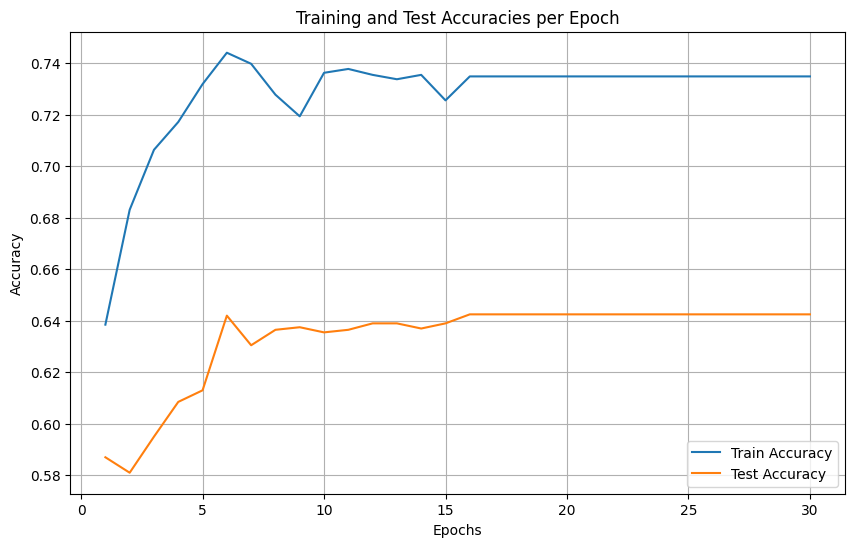

In [14]:
train_accuracies_np = cp.asnumpy(cp.array(final_train_accuracies))
test_accuracies_np = cp.asnumpy(cp.array(final_test_accuracies))

epochs = range(1, len(train_accuracies_np) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies_np, label='Train Accuracy')
plt.plot(epochs, test_accuracies_np, label='Test Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracies per Epoch')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()